# Plotting results of predictions




In [1]:
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import odc.geo
import numpy as np
from odc.geo.xr import assign_crs
from odc.algo import xr_reproject

import sys
sys.path.append('/g/data/os22/chad_tmp/dea-notebooks/Tools')
from dea_tools.temporal import allNaN_arg

## Analysis Parameters

In [2]:
var = 'NEE'
results_name = 'NEE_modelled_2003_2021.nc'
data_path = '/g/data/os22/chad_tmp/NEE_modelling/results/prediction_data/prediction_data_2003_2021.nc'

### Open datasets

In [3]:
ds = xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/results/predictions/'+results_name)
ds.attrs['nodata'] = np.nan

var_fc = 'nee'
ds_fc = assign_crs(xr.open_dataset('/g/data/os22/chad_tmp/NEE_modelling/data/FLUXCOM/'+var_fc+'_rs_meteo_era5.nc').sel(time=slice('2003','2018')), crs='epsg:4326')
ds_fc = ds_fc.rename({'lat':'latitude', 'lon':'longitude'})
ds_fc.attrs['nodata'] = np.nan
ds_fc['latitude'] = ds_fc.latitude.astype('float32')
ds_fc['longitude'] = ds_fc.longitude.astype('float32')

Reproject mask and predictions to match fluxcom

In [5]:
ds = xr_reproject(ds, geobox=ds_fc.geobox, resampling='average')
ds['latitude'] = ds.latitude.astype('float32')
ds['longitude'] = ds.longitude.astype('float32')

mask = np.isnan(ds.isel(time=1))

In [7]:
ds_fc = ds_fc.NEE.where(~mask.astype(bool))
ds_fc = ds_fc*30

## Zonal summaries

In [8]:
ds_1D = ds.sum(['latitude','longitude'])
ds_fc_1D = ds_fc.sum(['latitude','longitude'])

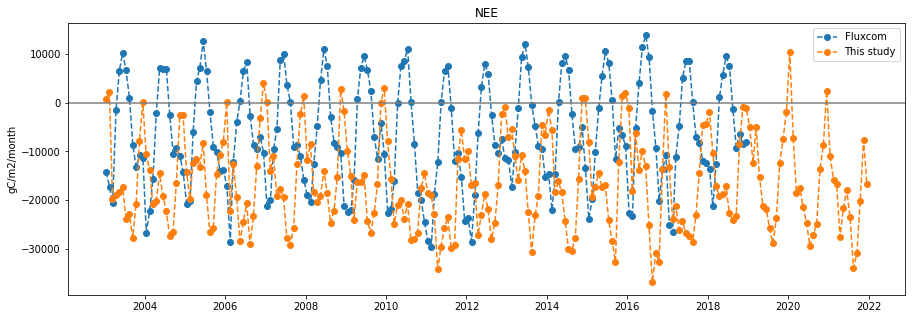

In [10]:
fig, ax = plt.subplots(1,1, figsize=(15,5))
ax.plot(ds_fc_1D.time.values, ds_fc_1D, marker='o', linestyle='--', label='Fluxcom')
ax.plot(ds_1D.time.values, ds_1D, marker='o', linestyle='--', label='This study')
ax.legend(loc='upper right')
plt.axhline(0, c='grey')
plt.title(var)
plt.ylabel('gC/m2/month');


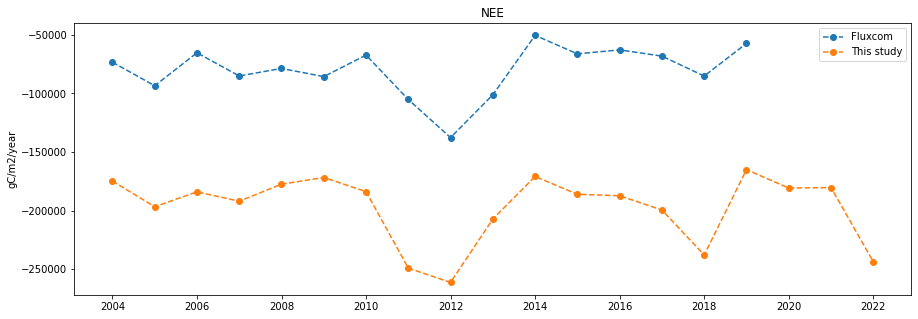

In [11]:
ds_1D_annual = ds.resample(time='1Y').sum().sum(['latitude','longitude'])
ds_fc_1D_annual = ds_fc.resample(time='1Y').sum().sum(['latitude','longitude'])
fig, ax = plt.subplots(1,1, figsize=(15,5))
ax.plot(ds_fc_1D_annual.time.values, ds_fc_1D_annual, marker='o', linestyle='--', label='Fluxcom')
ax.plot(ds_1D_annual.time.values, ds_1D_annual, marker='o', linestyle='--', label='This study')
# plt.axhline(0, c='grey')
plt.title(var)
ax.legend(loc='upper right')
plt.ylabel('gC/m2/year');

## Climatology

In [12]:
monthly_mean = ds.groupby('time.month').mean()
monthly_std = ds.groupby('time.month').std()
cv_monthly = monthly_std / monthly_mean

monthly_mean_fc = ds_fc.groupby('time.month').mean()
monthly_std_fc = ds_fc.groupby('time.month').std()
cv_monthly_fc = monthly_std_fc / monthly_mean_fc

/g/data/os22/chad_tmp/NEE_modelling/env/nee/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/g/data/os22/chad_tmp/NEE_modelling/env/nee/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/g/data/os22/chad_tmp/NEE_modelling/env/nee/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/g/data/os22/chad_tmp/NEE_modelling/env/nee/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/g/data/os22/chad_tmp/NEE_modelling/env/nee/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of f

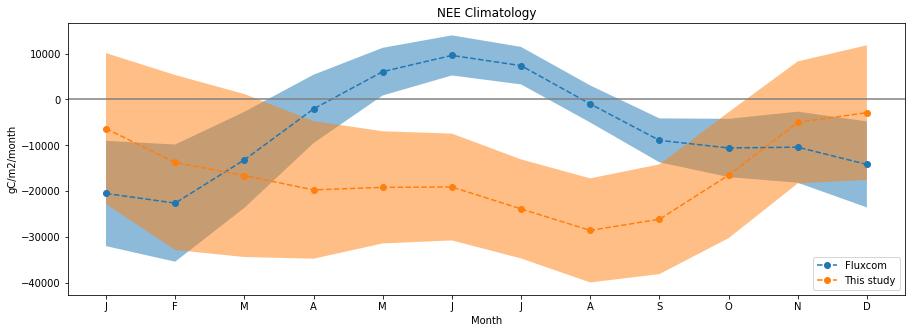

In [15]:
y = monthly_mean.where(~mask).sum(['latitude','longitude']).values
x = monthly_mean.month.values
std = monthly_std.where(~mask).sum(['latitude','longitude']).values

y_fc = monthly_mean_fc.where(~mask).sum(['latitude','longitude']).values
x_fc = monthly_mean_fc.month.values
std_fc = monthly_std_fc.where(~mask).sum(['latitude','longitude']).values

fig,ax = plt.subplots(1,1, figsize=(15,5))
ax.plot(x_fc, y_fc, marker='o', linestyle='--', label='Fluxcom')
ax.plot(x, y, marker='o', linestyle='--', label='This study')
ax.axhline(0, c='grey')
ax.fill_between(x_fc, y_fc-std_fc, y_fc+std_fc, alpha=0.5)
ax.fill_between(x, y-std, y+std, alpha=0.5)
ax.legend(loc='lower right')
ax.set_title('NEE Climatology')
ax.set_xlabel('Month')
ax.set_xticks(range(1,13))
ax.set_xticklabels(["J","F","M","A","M","J","J","A","S","O","N","D"])             
ax.set_ylabel('gC/m2/month');
